In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib tk

In [2]:
data = pd.read_csv('/home/lin/教材/MearchineLearning/assignmentOneData/CrisisPrediction.csv')

In [3]:
list(data.columns.values)

['year', 'country', 'loans1', 'cpi', 'credit_to_GDP', 'crisisST']

In [4]:
data['logRetCre'] = np.log(data['loans1']/data['cpi']).diff()

In [5]:
data['lag_1'] = data['logRetCre'].shift()
data['lag_2'] = data['logRetCre'].shift(2)
data['lag_3'] = data['logRetCre'].shift(3)
data['lag_4'] = data['logRetCre'].shift(4)
data['lag_5'] = data['logRetCre'].shift(5)
data['credit'] = data['credit_to_GDP'].shift()
data.sort_values('year', inplace=True)
data = data.dropna()
preW = data[data['year']<=1938]
postW = data[data['year']>=1948]

In [6]:
data.head(10)

,year,country,loans1,cpi,credit_to_GDP,crisisST,logRetCre,lag_1,lag_2,lag_3,lag_4,lag_5,credit
1108,1870,NOR,112.95840,2.363482,0.208410,0,-4.877423,0.019122,0.038468,0.036959,0.067692,0.084075,0.731451
810,1870,ITA,349.51901,0.021625,0.038835,0,7.209403,0.009891,0.081921,0.089989,0.091649,0.091014,1.240313
1226,1871,SWE,147.25800,2.623927,0.149991,0,-5.748062,0.056429,0.135382,0.139309,0.154463,0.060727,1.021129
1109,1871,NOR,120.03910,2.392305,0.213593,0,0.048677,-4.877423,0.019122,0.038468,0.036959,0.067692,0.208410
811,1871,ITA,459.50101,0.022397,0.049409,0,0.238492,7.209403,0.009891,0.081921,0.089989,0.091649,0.038835
110,1871,CAN,0.09320,6.380275,0.225830,0,-13.228011,0.090138,0.150262,0.092196,0.095436,0.092144,1.100622
1110,1872,NOR,128.30400,2.579654,0.200475,0,-0.008813,0.048677,-4.877423,0.019122,0.038468,0.036959,0.213593
812,1872,ITA,741.03802,0.025229,0.071254,0,0.358851,0.238492,7.209403,0.009891,0.081921,0.089989,0.049409
1227,1872,SWE,177.79100,2.719924,0.158784,0,0.152491,-5.748062,0.056429,0.135382,0.139309,0.154463,0.149991
111,1872,CAN,0.11670,6.971189,0.260899,0,0.136284,-13.228011,0.090138,0.150262,0.092196,0.095436,0.225830


auc: 0.6373277827336704
auc: 0.4518906730102092
auc: 0.6286424526999033
auc: 0.5177922018137459
auc: 0.697533908754624
auc: 0.7200369913686806


Text(0.5,0,'True positive rate')

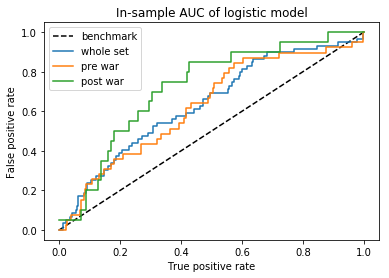

In [7]:
#logistic with whole data set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def in_sample_logistic(training, sign, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]
        #X = training[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'credit']]
#from the paper, lag_2 cpi nomalized loan is the most significent one and credit add prediction power, I tried all 
#five lags and it confirmed this results However, the credit seems mostly add power in post war period. Possible
#reason is prewar, credit to GBP is steady thus cannot add much info to predict crisis
    else:
        X = training[['lag_2']]
        #X = training[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

    y = training['crisisST']
    logis = LogisticRegression()
    logis.fit(X, sign * y)
    pre_pro = logis.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pre_pro)
    auc = roc_auc_score(y, pre_pro)
    

    print(f'auc: {auc}')
    return fpr, tpr, auc

data_fpr, data_tpr, _ = in_sample_logistic(data, -1)
in_sample_logistic(data, -1, True)

pre_fpr, pre_tpr, _ = in_sample_logistic(preW, -1)
in_sample_logistic(preW, -1, True)

in_sample_logistic(postW, 1)
post_fpr, post_tpr, _ = in_sample_logistic(postW, 1, True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.title('In-sample AUC of logistic model')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')

auc: 0.5861360718870345
auc: 0.5892169448010269
auc: 0.42370129870129875
auc: 0.5800865800865801
auc: 0.7608543417366948
auc: 0.38445378151260506


Text(0.5,0,'True positive rate')

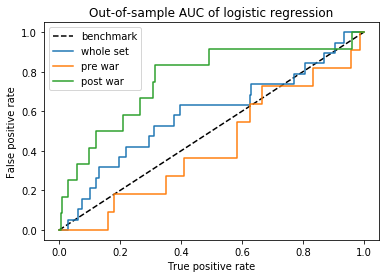

In [8]:
def out_of_sample_logistic(whole, test, sign, credit=False):
    if credit is True:
        #X = whole[['lag_2', 'credit']]
        X = whole[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'credit']]

    else:
        #X = whole[['lag_2']]
        X = whole[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    
    logis = LogisticRegression()
    logis.fit(X_train, sign * y_train)
    pre_pro = logis.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    print(f'auc: {auc}')
    return fpr, tpr, auc
    
whole_fpr, whole_tpr, _ = out_of_sample_logistic(data, 0.3, 1)
out_of_sample_logistic(data, 0.3, 1, True)

preW_fpr, preW_tpr, _ = out_of_sample_logistic(preW, 0.3, 1)
out_of_sample_logistic(preW, 0.3, -1, True)

postW_fpr, postW_tpr, _ = out_of_sample_logistic(postW, 0.3, 1)
out_of_sample_logistic(postW, 0.3, 1, True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(whole_fpr,whole_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.title('Out-of-sample AUC of logistic regression')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')

auc: 0.7370988446726572
auc: 0.531193838254172
auc: 0.7976190476190476
auc: 0.6737012987012987
auc: 0.7461484593837535
auc: 0.6355042016806722


Text(0.5,0,'True positive rate')

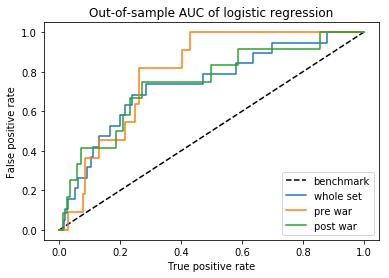

In [9]:
def out_of_sample_logistic(whole, test, sign, credit=False):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]    

    logis = LogisticRegression()
    logis.fit(X_train, sign * y_train)
    pre_pro = logis.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)
    to_rank = pd.DataFrame()
    to_rank['prob'] = pre_pro
    to_rank['true'] = y_test.values
   
    print(f'auc: {auc}')
   
    return fpr, tpr, auc, to_rank
    
whole_fpr, whole_tpr, _ , whToRank = out_of_sample_logistic(data, 0.3, -1)
out_of_sample_logistic(data, 0.3, 1, True)

preW_fpr, preW_tpr, _ , preToRank = out_of_sample_logistic(preW, 0.3, -1)
out_of_sample_logistic(preW, 0.3, -1, True)

postW_fpr, postW_tpr, _, postToRank = out_of_sample_logistic(postW, 0.3, 1)
out_of_sample_logistic(postW, 0.3, -1, True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(whole_fpr,whole_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.title('Out-of-sample AUC of logistic regression')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')

In [10]:
whToRank.sort_values('prob', ascending=False, inplace=True)
thresholds = np.unique(whToRank['prob'][whToRank['true']==1])
print('|threshold|sensitiveity|falseAlarm|totalFlag|')

for i in np.flip(thresholds, axis=0):
    modPosi = whToRank[whToRank['prob']>=i]
    M11 = modPosi[modPosi['true']==1].shape[0]
    M01 = modPosi.shape[0] - M11
    modNega = whToRank[whToRank['prob']<i]
    M10 = modNega[modNega['true']==1].shape[0]
    M00 = modNega.shape[0] - M10
    sensitivity = M11 /(M11 + M10) #percentage of crisis that was caught
    falseAlarm = M01/ modPosi.shape[0] #percentage of false alarm
    totalFlag = modPosi.shape[0] / whToRank.shape[0]
    
    print(f'|{i}|{sensitivity}|{falseAlarm}|{totalFlag}|')

|threshold|sensitiveity|falseAlarm|totalFlag|
|0.9584492738912054|0.05263157894736842|0.875|0.018648018648018648|
|0.9584156227543202|0.10526315789473684|0.8|0.023310023310023312|
|0.9582944101957735|0.15789473684210525|0.8|0.03496503496503497|
|0.9581720526209747|0.21052631578947367|0.84|0.05827505827505827|
|0.9581434201492378|0.2631578947368421|0.8333333333333334|0.06993006993006994|
|0.9580476223194564|0.3157894736842105|0.8604651162790697|0.10023310023310024|
|0.9580060539159138|0.3684210526315789|0.86|0.11655011655011654|
|0.9579924986498776|0.42105263157894735|0.8518518518518519|0.1258741258741259|
|0.9579584325457295|0.47368421052631576|0.8571428571428571|0.14685314685314685|
|0.9579263005580301|0.5263157894736842|0.8717948717948718|0.18181818181818182|
|0.9579072932281031|0.5789473684210527|0.8817204301075269|0.21678321678321677|
|0.9578986698802621|0.631578947368421|0.8811881188118812|0.23543123543123542|
|0.9578854148873172|0.6842105263157895|0.8828828828828829|0.25874125874

In [13]:
total = 0.0
for i in range(2, 5):
    wholeSet = data[:int(data.shape[0]*(i/4.0))]
    _, _, auc, _ = out_of_sample_logistic(wholeSet, (1.0/i), -1, True)
    total += auc

avg = total/3
avg
#prediction power OK for the whole set to slice into 5 block

auc: 0.6089129529362766
auc: 0.5647887323943661
auc: 0.5101606030809571


0.5612874294705333

auc: 0.6937568143522649
auc: 0.7598684210526315
auc: 0.7030106338903466
auc: 0.7878746029553929
auc: 0.780209617755857
auc: 0.8358199753390876


Text(0.5,0,'True positive rate')

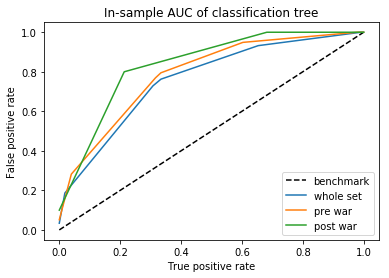

In [14]:
from sklearn import tree
import graphviz 
#criterion=”gini”)
#“entropy” for the information gain
#entropy is nuts

def in_sample_tree(training, maxD = 3, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD)
    treeClas.fit(X, y)
    pre_pro = treeClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(f'auc: {auc}')
    return fpr, tpr, auc

in_sample_tree(data)
data_fpr, data_tpr, _ = in_sample_tree(data, credit=True)

in_sample_tree(preW)
pre_fpr, pre_tpr, _ = in_sample_tree(preW, credit=True)

in_sample_tree(postW)
post_fpr, post_tpr, _ = in_sample_tree(postW, credit=True)
#by changing maxD, all of these have the protetial to get auc to 1.0

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.title('In-sample AUC of classification tree')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')
#picture looks like this is because of the number of threshold
#np.unique(pre_pro).shape == thr.shape == fpr.shape == tpr.shape

#This part really cannot do much compare, since tree has the protential to get 1.0 auc. So this is just a demostration

In [20]:
def out_of_sample_tree(whole, test, maxD = 3, credit=False, pri=False, criterion='gini'):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    if criterion=='gini':
        treeClas = tree.DecisionTreeClassifier(criterion='gini', max_features='auto', max_depth=maxD, random_state=60)
    elif criterion=='entropy':
        treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD)
    treeClas.fit(X_train, y_train)
    pre_pro = treeClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)
    print('y_test')
    print(y_test)
    print('pre_pro')
    print(pre_pro)
    if pri:
        print(f'auc: {auc}')
    return fpr, tpr, auc

#out of sample can compare gini and entropy

Text(0.5,1,'Average AUC against maxmum depth')

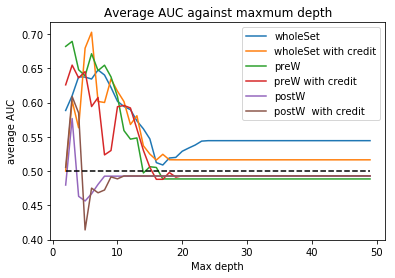

In [16]:
#basically cross validation to get optimal depth
realDeap = 50
testOF = pd.DataFrame(index=range(2, realDeap), columns=['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
for maxDeepth in range(2, realDeap):
    totalW = 0.0
    totalWC = 0.0
    totalPre = 0.0
    totalPreC = 0.0
    totalPos = 0.0
    totalPosC = 0.0
    for i in range(2, 6):
        _, _, auc = out_of_sample_tree(data, (1.0/i), maxDeepth)
        totalW += auc
        _, _, auc = out_of_sample_tree(data, (1.0/i), maxDeepth,  True)
        totalWC += auc

        _, _, auc = out_of_sample_tree(preW, (1.0/i), maxDeepth)
        totalPre += auc
        _, _, auc = out_of_sample_tree(preW, (1.0/i), maxDeepth, True)
        totalPreC += auc

        _, _, auc = out_of_sample_tree(postW, (1.0/i), maxDeepth)
        totalPos += auc

        _, _, auc = out_of_sample_tree(postW, (1.0/i), maxDeepth, True)
        totalPosC += auc

    testOF['wholeSet'][maxDeepth] = totalW/4
    testOF['wholeSet with credit'][maxDeepth] = totalWC/4
    testOF['preW'][maxDeepth] = totalPre/4
    testOF['preW with credit'][maxDeepth] = totalPreC/4
    testOF['postW'][maxDeepth] = totalPos/4
    testOF['postW  with credit'][maxDeepth]= totalPosC/4
plt.figure()               
plt.plot(range(2, realDeap), testOF)
plt.plot(range(2, realDeap), np.ones(realDeap - 2)*0.5, 'k--')
plt.legend(['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
plt.xlabel('Max depth')
plt.ylabel('average AUC')
plt.title('Average AUC against maxmum depth')

y_test
288     0
1320    0
999     0
789     0
390     0
904     0
1206    0
391     0
1000    0
207     0
1088    0
790     0
576     0
491     0
90      1
1321    0
1413    0
289     0
682     0
905     0
906     1
91      0
1089    0
1207    0
492     0
290     0
683     0
1322    0
1001    0
577     0
       ..
807     0
508     0
409     0
307     0
1339    0
594     0
225     0
700     0
108     0
808     1
923     0
1018    0
1106    0
1224    0
509     0
1431    1
226     0
109     0
410     1
510     0
595     1
701     1
1340    1
809     0
924     1
1019    0
1107    1
1225    0
308     1
1432    0
Name: crisisST, Length: 286, dtype: int64
pre_pro
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0

Text(0.5,1,'AUC when models are over fitted')

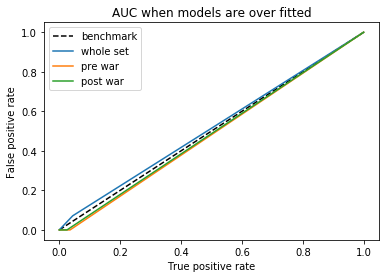

In [21]:
#out of sample test, gini outperform entropy, can quickly run entropy when writing report
data_fpr, data_tpr, _ = out_of_sample_tree(data, 0.20, 25, credit=True, pri=True )
preW_fpr, preW_tpr, _ = out_of_sample_tree(preW, 0.20, 25, credit=True, pri=True )
postW_fpr, postW_tpr, _ = out_of_sample_tree(postW, 0.20, 25, True, True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')
plt.title('AUC when models are over fitted')

In [18]:
data_fpr

array([0.        , 0.04411765, 1.        ])

In [19]:
data_tpr

array([0.        , 0.07142857, 1.        ])

In [14]:
import math
got = {}
for index, row in testOF[testOF==testOF.max(axis=0)].iterrows():
    for key in row.keys():
        if not math.isnan(row[key]):
            got[key] = index
got
    

{'postW': 3,
 'postW  with credit': 3,
 'preW': 3,
 'preW with credit': 4,
 'wholeSet': 7,
 'wholeSet with credit': 5}

410 0 19 0
false alarm: nan
missing target: 0.04428904428904429
auc: 0.5600770218228498
166 2 11 0
false alarm: 1.0
missing target: 0.062146892655367235
auc: 0.6350108225108225
236 2 12 0
false alarm: 1.0
missing target: 0.04838709677419355
auc: 0.4411764705882353


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


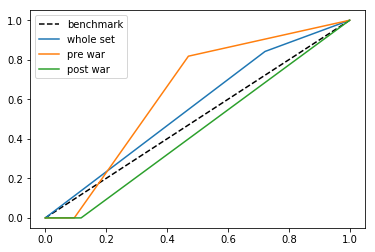

In [225]:
#out of sample test, gini outperform entropy, can quickly run entropy when writing report
data_fpr, data_tpr, _ = out_of_sample_tree(data, 0.3, 3, credit=True, pri=True )
preW_fpr, preW_tpr, _ = out_of_sample_tree(preW, 0.3, 3, credit=True, pri=True )
postW_fpr, postW_tpr, _ = out_of_sample_tree(postW, 0.3, 5, True, True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

In [422]:

def in_sample_treePlot(training, maxD = 3, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    treeClas = tree.DecisionTreeClassifier(criterion='entropy', max_depth=maxD, max_features='auto', random_state=None)
    treeClas.fit(X, y)
    pre_pro = treeClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    dot_data = tree.export_graphviz(treeClas, out_file=None, 
                         feature_names=['lag_2', 'credit'],  
                         class_names='crisis',  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    
    prediction = treeClas.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
    print(tn, fp, fn, tp)
    false_alarm = fp/(1.0*tp + fp)
    missing_target = fn/(1.0*fn + tn)

    print(f'auc: {auc}')
    print(f'false alarm: {false_alarm}')
    print(f'missing target: {missing_target}')
    return graph

#in_sample_treePlot(postW, credit=True)


in_sample_treePlot(postW, credit=True).render(filename='/home/lin/教材/MearchineLearning/assignmentOneReport/app_samedata_2.pdf')


811 0 18 2
auc: 0.8458076448828606
false alarm: 0.0
missing target: 0.021712907117008445


'/home/lin/教材/MearchineLearning/assignmentOneReport/app_samedata_2.pdf.pdf'

In [394]:
from sklearn.ensemble import RandomForestClassifier
def in_sample_forest(training, maxD = 3, credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]

    else:
         X = training[['lag_2']]
    y = training['crisisST']
    foreClas = RandomForestClassifier(criterion='gini', max_depth=maxD)
    foreClas.fit(X, y)
    pre_pro = foreClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(f'auc: {auc}')
    
    return fpr, tpr, auc

in_sample_forest(data)
data_fpr, data_tpr, _ = in_sample_forest(data, credit=True)

in_sample_forest(preW)
pre_fpr, pre_tpr, _ = in_sample_forest(preW, credit=True)

post_fpr, post_tpr, _ = in_sample_forest(postW)
in_sample_forest(postW, credit=True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])
plt.title('In-sample AUC of classification forest')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')
#with default depth 3, greatly out perform tree

auc: 0.7605622460105066
auc: 0.7840965407869958
auc: 0.8095797081434425
auc: 0.8340928969295217
auc: 0.8978113440197287
auc: 0.9462392108508015


Text(0.5,0,'True positive rate')

In [406]:
def out_of_sample_forest(whole, test, maxD = 3, credit=False, pri=False, criterion='gini'):
    if credit is True:
        X = whole[['lag_2', 'credit']]
    else:
         X = whole[['lag_2']]
    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    if criterion=='gini':
        foreClas = RandomForestClassifier(criterion='gini', max_features='auto', max_depth=maxD, random_state=None, bootstrap=False)
    elif criterion=='entropy':
        foreClas = RandomForestClassifier(criterion='entropy', max_depth=maxD)
    foreClas.fit(X_train, y_train)
    pre_pro = foreClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    to_rank = pd.DataFrame()
    to_rank['prob'] = pre_pro
    to_rank['true'] = y_test.values

    if pri:
        print(f'auc: {auc}')
    return fpr, tpr, auc, to_rank

#out of sample can compare gini and entropy

In [408]:
#basically cross validation to get optimal depth
realDeap = 50
testOF = pd.DataFrame(index=range(2, realDeap), columns=['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
for maxDeepth in range(2, realDeap):
    totalW = 0.0
    totalWC = 0.0
    totalPre = 0.0
    totalPreC = 0.0
    totalPos = 0.0
    totalPosC = 0.0
    for i in range(2, 6):
        _, _, auc, _ = out_of_sample_forest(data, (1.0/i), maxDeepth)
        totalW += auc
        _, _, auc, _  = out_of_sample_forest(data, (1.0/i), maxDeepth,  True)
        totalWC += auc

        _, _, auc, _  = out_of_sample_forest(preW, (1.0/i), maxDeepth)
        totalPre += auc
        _, _, auc, _  = out_of_sample_forest(preW, (1.0/i), maxDeepth, True)
        totalPreC += auc

        _, _, auc, _  = out_of_sample_forest(postW, (1.0/i), maxDeepth)
        totalPos += auc

        _, _, auc, _  = out_of_sample_forest(postW, (1.0/i), maxDeepth, True)
        totalPosC += auc

    testOF['wholeSet'][maxDeepth] = totalW/4
    testOF['wholeSet with credit'][maxDeepth] = totalWC/4
    testOF['preW'][maxDeepth] = totalPre/4
    testOF['preW with credit'][maxDeepth] = totalPreC/4

    testOF['postW'][maxDeepth] = totalPos/4
    testOF['postW  with credit'][maxDeepth]= totalPosC/4
plt.figure()
plt.plot(range(2, realDeap), testOF)
plt.plot(range(2, realDeap), np.ones(realDeap - 2)*0.5, 'k--')
plt.legend(['wholeSet', 'wholeSet with credit', 'preW', 'preW with credit', 'postW', 'postW  with credit'])
plt.title('Limited max feature with no bootstrap')
plt.xlabel('Max depth')
plt.ylabel('average AUC')
    
#waht is this pattern? Seems forest already take care of some cross validation

Text(0,0.5,'average AUC')

In [346]:
import math
got = {}
for index, row in testOF[testOF==testOF.max(axis=0)].iterrows():
    for key in row.keys():
        if not math.isnan(row[key]):
            got[key] = index
got
    

{'postW': 3,
 'postW  with credit': 3,
 'preW': 3,
 'preW with credit': 4,
 'wholeSet': 7,
 'wholeSet with credit': 5}

In [353]:
data_fpr, data_tpr, _, whToRank = out_of_sample_forest(data, 0.3, 3,  False, True)
preW_fpr, preW_tpr, _, _  = out_of_sample_forest(preW, 0.3, 3, False, pri=True)#a bit deeper
postW_fpr, postW_tpr, _, _  = out_of_sample_forest(postW, 0.3, 5, True, True)#max depth lower
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(preW_fpr,preW_tpr)
plt.plot(postW_fpr,postW_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

auc: 0.6707958921694479
auc: 0.6204004329004329
auc: 0.5133053221288516


In [361]:
whToRank.sort_values('prob', ascending=False, inplace=True)
thresholds = np.unique(whToRank['prob'][whToRank['true']==1])
print('|threshold|sensitiveity|falseAlarm|totalFlag|')

for i in np.flip(thresholds, axis=0):
    modPosi = whToRank[whToRank['prob']>=i]
    M11 = modPosi[modPosi['true']==1].shape[0]
    M01 = modPosi.shape[0] - M11
    modNega = whToRank[whToRank['prob']<i]
    M10 = modNega[modNega['true']==1].shape[0]
    M00 = modNega.shape[0] - M10
    sensitivity = M11 /(M11 + M10) #percentage of crisis that was caught
    falseAlarm = M01/ modPosi.shape[0] #percentage of false alarm
    totalFlag = modPosi.shape[0] / whToRank.shape[0]
    
    print(f'|{i}|{sensitivity}|{falseAlarm}|{totalFlag}|')

|threshold|sensitiveity|falseAlarm|totalFlag|
|0.31087996870780027|0.05263157894736842|0.0|0.002331002331002331|
|0.15586808878177918|0.10526315789473684|0.5|0.009324009324009324|
|0.0538083675328781|0.15789473684210525|0.9090909090909091|0.07692307692307693|
|0.047849724485387976|0.3684210526315789|0.8939393939393939|0.15384615384615385|
|0.04160062144965254|0.7368421052631579|0.9366515837104072|0.5151515151515151|
|0.03808155845225508|0.8421052631578947|0.9382239382239382|0.6037296037296037|
|0.03176986812156413|0.8947368421052632|0.9388489208633094|0.6480186480186481|
|0.010696363086234579|0.9473684210526315|0.95|0.8391608391608392|
|0.00829026056619624|1.0|0.9557109557109557|1.0|


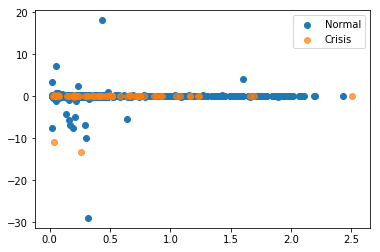

In [160]:
Crisis = data[data['crisisST'] == 1]
Normal = data[data['crisisST'] == 0]
#%matplotlib tk
plt.scatter(Normal['credit'], Normal['lag_2'])
plt.scatter(Crisis['credit'], Crisis['lag_2'], alpha = 0.7)
plt.legend(['Normal', 'Crisis'])
#based on this plot I dont think linear line will do well

In [374]:
from sklearn.svm import SVC


def in_sample_SVM(training, kernel = 'sigmoid', credit=False):
    if credit is True:
        X = training[['lag_2', 'credit']]
        #X = training[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'credit']]

    else:
        X = training[['lag_2']]
        #X = training[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

    y = training['crisisST']
    svmClas = SVC(kernel=kernel, probability=True)
    svmClas.fit(X, y)
    pre_pro = svmClas.predict_proba(X)[:, 1]
    fpr, tpr, thr = roc_curve(y, pre_pro, drop_intermediate=False)
    auc = roc_auc_score(y, pre_pro)
    
    print(f'auc: {auc}')
    
    return fpr, tpr, auc

in_sample_SVM(data)
data_fpr, data_tpr, _ = in_sample_SVM(data, credit=True)

in_sample_SVM(preW)
pre_fpr, pre_tpr, _ = in_sample_SVM(preW, credit=True)

in_sample_SVM(postW)
post_fpr, post_tpr, _ = in_sample_SVM(postW, credit=True)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(data_fpr,data_tpr)
plt.plot(pre_fpr,pre_tpr)
plt.plot(post_fpr,post_tpr)
plt.legend(['benchmark', 'whole set', 'pre war', 'post war'])

auc: 0.3312270789969273
auc: 0.6492714837942314
auc: 0.32357409197624637
auc: 0.6429590756341205
auc: 0.694327990135635
auc: 0.6645499383477188


In [24]:
#kernel : string, optional (default=’rbf’)
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
#degree : int, optional (default=3)
#study this sigmoid kernel and include in report

In [379]:
def out_of_sample_SVM(whole, test, kernel = 'sigmoid', credit=False):
    if credit is True:
        X = whole[['lag_2', 'credit']]
        #X = whole[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'credit']]

    else:
        X = whole[['lag_2']]
        #X = whole[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]

    y = whole['crisisST']
    
    trainSize = int(whole.shape[0]*(1-test))
    X_train = X[:trainSize]
    X_test = X[trainSize:]
    y_train = y[:trainSize]
    y_test = y[trainSize:]
    
    svmClas = SVC(kernel=kernel, probability=True)
    svmClas.fit(X_train, y_train)
    pre_pro = svmClas.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pre_pro)
    auc = roc_auc_score(y_test, pre_pro)

    print(auc)
    return fpr, tpr, auc

In [380]:
totalW = 0.0
totalWC = 0.0
totalPre = 0.0
totalPreC = 0.0
totalPos = 0.0
totalPosC = 0.0
for i in range(2, 6):
    _, _, auc = out_of_sample_SVM(data, (1.0/i))
    totalW += auc
    _, _, auc = out_of_sample_SVM(data, (1.0/i),  credit=True)
    totalWC += auc

    _, _, auc = out_of_sample_SVM(preW, (1.0/i))
    totalPre += auc
    _, _, auc = out_of_sample_SVM(preW, (1.0/i), credit=True)
    totalPreC += auc

    _, _, auc = out_of_sample_SVM(postW, (1.0/i))
    totalPos += auc

    _, _, auc = out_of_sample_SVM(postW, (1.0/i), credit=True)
    totalPosC += auc

print(f'whole set with lag2 loan only: {totalW/4}')
print(f'whole set with lag2 loan and lag1 credit to GDP: {totalWC/4}')
print(f'pre WW2 with lag2 loan only: {totalPre/4}')
print(f'pre WW2 with lag2 loan and lag2 credit to GDP: {totalPreC/4}')
print(f'post WW2 with lag2 loan only: {totalPos/4}')
print(f'post WW2 with lag2 loan and lag2 credit to GDP: {totalPosC/4}')

0.30180115273775215
0.26318443804034586
0.7187351778656126
0.7010276679841898
0.24329983249581238
0.7490228922389726
0.7370724404007831
0.6745364505355291
0.7890818858560794
0.24483043837882545
0.7479630635524172
0.7533948940793048
0.7515568666011144
0.6943625040970174
0.8057553956834533
0.7755395683453237
0.7118927973199329
0.4896705750977108
0.7457983193277311
0.6683298319327732
0.8457648546144121
0.7914032869785083
0.679324894514768
0.5260196905766525
whole set with lag2 loan only: 0.6340571947668452
whole set with lag2 loan and lag1 credit to GDP: 0.5751033061514164
pre WW2 with lag2 loan only: 0.7898343285048894
pre WW2 with lag2 loan and lag2 credit to GDP: 0.6282002404217119
post WW2 with lag2 loan only: 0.5956201469707326
post WW2 with lag2 loan and lag2 credit to GDP: 0.6295270129981603
